In [2]:
# import statements
from scipy.integrate import ode, solve_ivp # ordinary diff equations solver
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [51]:
class seir_model:
    """
    Intantiates a seir_model object.
    """

    def __init__(self, N=1e3, time_range=10):
        """
        Initializes the model with default parameters.

        Args:
            N (int, optional): [Population size]. Defaults to 1e3.
            time_range (int, optional): [Simulation time in days]. Defaults to 10.
        """    
        # model parameters
        self.time_range = time_range # simulation duration in days
        self.beta = 0.3 # time varying transmission rate, initial value
        self.Z = 3.69 # average time, in days, for exposed to become infected
        self.alpha = 0.6 # reported infections rate (Ir/Ir+In)
        self.D = 7.0 # average time, in days, for the infection duration. 

        # initial infection parameters
        self.N = N # initial number of individuals in the population
        self.S = 0.9 * N # initial number of susceptible individuals
        self.E = 0.4 * N # initial number of exposed individuals
        self.Ir = 0.4 * N # initial number of reported infected individuals
        self.In = 0.1 * N # initial number of non-reported infected individuals
        self.R = 0.01 * N # initial number of recovered
        self.I = self.Ir + self.In # total infected

        self.solution = self.solve_seir_function()

    def seir_function(self, t, y, beta, Z, alpha, D):
        """
        Defines the function to be solved in the Initial Value Problem.

        Args:
            t (float): [Time to be varied]
            y ([array of floats]): [Contains the infection parameters]
            beta ([float]): [Transmission rate]
            Z ([float]): [Average time for infection, days]
            alpha ([float]): [Reported infections rate]
            D ([float]): [Average time for the infection duration, days]

        Returns:
            [array of floats]: [returns the deterministic equations]
        """        
        S, E, In, Ir, R, N = y

        # model compartments
        dSdt = (-beta/N)*S*I # susceptible individuals time varying rate
        dEdt = (beta/N)*S*I - (1/Z)*E # exposed individuals time varying rate
        dIrdt = (alpha/Z)*E - (1/D)*Ir # reported infections time varying rate
        dIndt = ((1-alpha)/Z)*E - (1/D)*In # non reported infections time varying rate
        dRdt = (1/D)*I # recovered individuals time varying rate

        return np.array([dSdt, dEdt, dIrdt, dIndt, dRdt, N])


    def solve_seir_function(self):
        """
        Solves the seir function based on initial values, uses scipy.integrate.

        Returns:
            [object]: [Solution object]
        """        
        solver = solve_ivp(self.seir_function,
                            [0, self.time_range],
                            [self.S, self.E, self.In, self.Ir, self.R, self.N],
                            t_eval = np.array(range(self.time_range)),
                            method = 'RK45',
                            args = [self.beta, self.alpha, self.Z, self.D])
        return solver


    def plot_results(self):
        """
        Plots the results using matplotlib, based on object values.
        """        
        S_solved = self.solution.y[0]
        E_solved = self.solution.y[1]
        In_solved = self.solution.y[2]
        Ir_solved = self.solution.y[3]
        R_solved = self.solution.y[4]
        time_solved = self.solution.t
        vals = [S_solved, E_solved, In_solved, Ir_solved, R_solved]
        labels = ['S', 'E', 'In', 'Ir', 'R']

        fig, ax = plt.subplots(figsize=(15,5))
        for var in vals:
            plt.plot(time_solved, var)

        plt.legend(labels)

In [6]:
# model parameters
beta = 0.3 # time varying transmission rate, initial value
Z = 3.69 # average time, in days, for exposed to become infected
alpha = 0.6 # reported infections rate (Ir/Ir+In)
D = 7.0 # average time, in days, for the infection duration. 
time_range = 10 # simulation duration in days

# infection parameters
N = 1e3 # initial number of individuals in the population
S = 0.9*N # initial number of susceptible individuals
Ir = 0.1*N # initial number of reported infected individuals
In = 0.1*N # initial number of non-reported infected individuals
E = 0.4*N # initial number of exposed individuals
R = 10
I = Ir + In

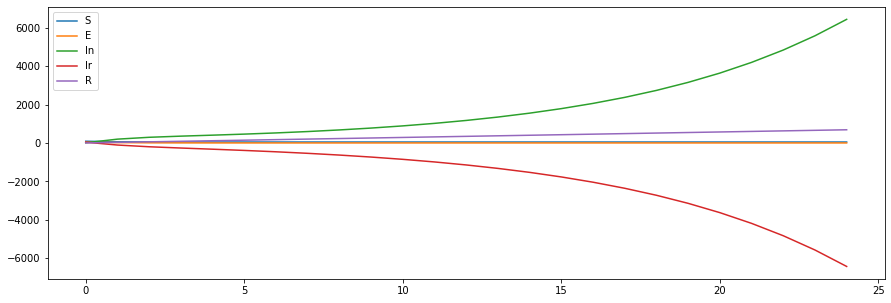

In [53]:
model = seir_model(100, 25)
model.plot_results()

In [44]:
# solve initial value problem
solver = solve_ivp(seir_f,
          [0, time_range],
          [S, E, In, Ir, R, N],
          t_eval = np.array(range(time_range)),
          method = 'RK45',
          args = [beta, alpha, Z, D])

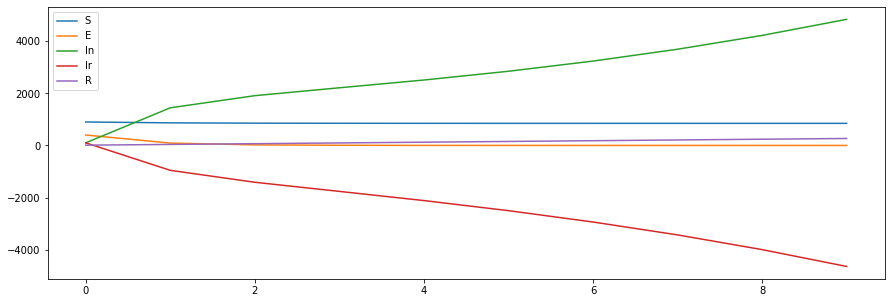

In [18]:
# plot values
S_solved = solver.y[0]
E_solved = solver.y[1]
In_solved = solver.y[2]
Ir_solved = solver.y[3]
R_solved = solver.y[4]
time_solved = solver.t
vals = [S_solved, E_solved, In_solved, Ir_solved, R_solved]
labels = ['S', 'E', 'In', 'Ir', 'R']

fig, ax = plt.subplots(figsize=(15,5))
for var in vals:
    plt.plot(time_solved, var)

plt.legend(labels)

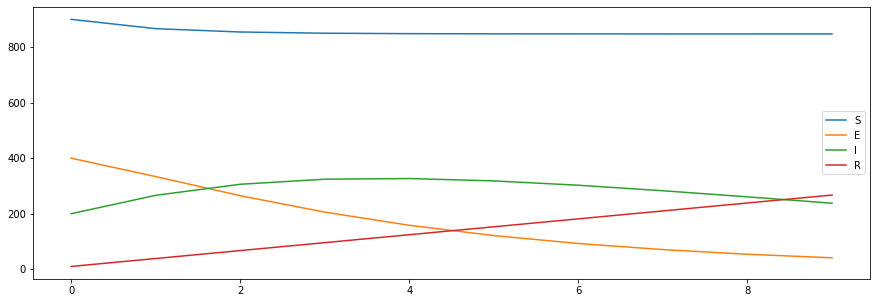

In [58]:
# plot values
S_solved = solver.y[0]
E_solved = solver.y[1]
In_solved = solver.y[2]
Ir_solved = solver.y[3]
R_solved = solver.y[4]
time_solved = solver.t
vals = [S_solved, E_solved, In_solved + Ir_solved, R_solved]
labels = ['S', 'E', 'I', 'R']

fig, ax = plt.subplots(figsize=(15,5))
for var in vals:
    plt.plot(time_solved, var)

plt.legend(labels)